In [1]:
import itertools
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt


random.seed(0)


def benchmark(
        funcs,
        argss=None,
        kwss=None,
        input_sizes=(5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000),
        gen_input=lambda n: [random.random() for _ in range(n)],
        equal_output=lambda a, b: a == b,
        store_all=False):
    runtimes = np.zeros((3, len(input_sizes), len(funcs)))
    labels = [func.__name__ for func in funcs]
    if argss is None: argss = ()
    if kwss is None: kwss = ()
    results = [] if store_all else None
    for i, input_size in enumerate(input_sizes):
        input_data = gen_input(input_size)
        truth = None
        for j, (func, args, kws) in \
                enumerate(itertools.zip_longest(funcs, argss, kwss)):
            args = tuple(args) if args is not None else ()
            kws = dict(kws) if kws is not None else {}
            result = func(input_data, *args, **kws)
            if truth is None and j == 0:
                truth = result
            is_equal = 1.0 if equal_output(result, truth) else -1.0
            print(':{lbl:<20s} N={n!s:<8s} {eq:>4s}  '.format(
                lbl=labels[j], n=input_size, eq='OK' if is_equal > 0 else 'FAIL'),
                end='')
            timing_result = %timeit -o func(input_data, *args, **kws)
            if store_all:
                results.append(result)
            runtimes[:, i, j] = is_equal, timing_result.average, timing_result.stdev
        print()
    return runtimes, input_sizes, labels, results


def plot_benchmarks(
        runtimes,
        input_sizes,
        labels,
        panels=('Small', 'Medium', 'Large'),
        units='µs',
        save_filepath='benchmarks.png',
        dry=True):
    num_panels = len(panels)
    subplot_shape = 1, num_panels
    fig, axs = plt.subplots(
        *subplot_shape, squeeze=False, figsize=(16, 4))
    if units == 'ms':
        units_factor = 1e3
    elif units == 'µs':
        units_factor = 1e6
    elif units == 'ns':
        units_factor = 1e9
    else:
        units_factor = 1
    for i, panel in enumerate(panels):
        ij = np.unravel_index(i, subplot_shape)
        plot_sizes = int(len(input_sizes) * ((i + 1) / num_panels))
        axs[ij].set_title(panel)
        axs[ij].set_xlabel('Input Sizes / #')
        axs[ij].set_ylabel('Timings / ' + units)
        for k, label in enumerate(labels):
            x = input_sizes[:plot_sizes]
            y = runtimes[1, :plot_sizes, k] * units_factor
            dy = runtimes[2, :plot_sizes, k] * units_factor
            axs[ij].plot(x, y, label=label)
            axs[ij].fill_between(x, y - dy, y + dy, alpha=0.25)
            axs[ij].legend()
    if save_filepath and not dry:
        fig.tight_layout()
        fig.savefig(save_filepath.replace(' ', '_'))

In [2]:
def f1(items):
    return [item * item for item in items]


def f2(items):
    return [item ** 2 for item in items]


def gen_input(n):
    return [random.random() for _ in range(n)]


def equal_output(a, b):
    return a == b


input_sizes = (5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000)  
# input_sizes = (5, 10, 50, 100, 500, 1000, 5000)  # for n² problems
funcs = f1, f2


runtimes, input_sizes, labels, results = benchmark(
    funcs, gen_input=gen_input, equal_output=equal_output,
    input_sizes=input_sizes)

:f1                   N=5          OK  418 ns ± 6.85 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
:f2                   N=5          OK  553 ns ± 7.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

:f1                   N=10         OK  553 ns ± 12.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
:f2                   N=10         OK  808 ns ± 2.03 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

:f1                   N=50         OK  1.71 µs ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
:f2                   N=50         OK  2.88 µs ± 82.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

:f1                   N=100        OK  3.16 µs ± 40.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
:f2                   N=100        OK  5.38 µs ± 161 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

:f1                   N=500        OK  15.3 µs ± 243 ns per loop (mean ± std. dev. o

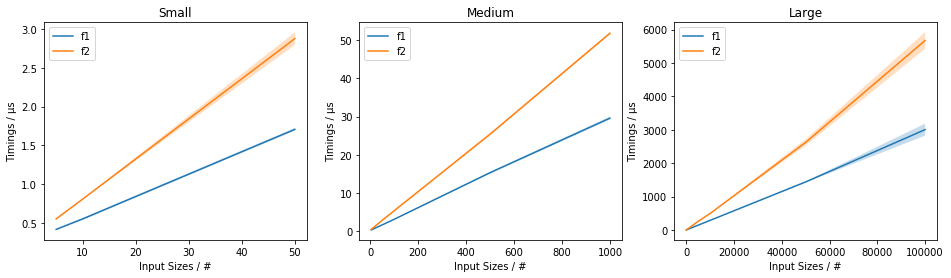

In [3]:
plot_benchmarks(runtimes, input_sizes, labels)